**Imports**

In [ ]:
import os
import fnmatch
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset

**Creates a custom dataset class that inherits from the `torch.utils.data.Dataset` class and implements the `__len__` and `__getitem__` methods. Resize images to 500x375 and transform them into tensors. Create Torchvision dataset and data loader used for training.**

In [61]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_map = {'rock': 0, 'paper': 1, 'scissors': 2}
        self.images = []
        self.targets = []
        pattern = '*.jpg'

        for file in os.listdir(self.root_dir):
            # If file is a .jpg file, add it to images list
            if fnmatch.fnmatch(file, pattern):
                # Get target label from file name
                target = self.labels_map[file.split('_')[0]]
                # Get full path of image file
                img_path = os.path.join(self.root_dir, file)

                self.images.append(img_path)
                self.targets.append(target)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        target = self.targets[idx]
        with open(img_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

DATA_PATH = os.path.join(os.getcwd(), '..', 'data/training_data')

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((500, 375)),
    torchvision.transforms.ToTensor()
])

train_dataset = MyDataset(root_dir=DATA_PATH, transform=train_transform)

batch_size = 4
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

**Visualize First Batch of Torchvision dataloader**

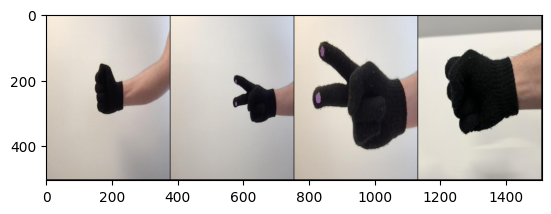

rock  scissors scissors rock 


In [9]:
classes = ('rock', 'paper', 'scissors')

# Function to display samples from dataset
def imshow(img):
    np_arr = img.numpy()
    plt.imshow(np.transpose(np_arr, (1, 2, 0)))
    plt.show()

# Get a batch of random training images and labels
data_iter = iter(dataloader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[i]]:5s}' for i in range(batch_size)))

**Create a Neural Network class that inherits from the PyTorch Neural Network Module**

In [63]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Define the max pooling layer
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define the linear layers
        self.fc1 = torch.nn.Linear(128 * 62 * 46, 512)
        self.fc2 = torch.nn.Linear(512, 3)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))

        # Flatten the output tensor
        x = x.view(-1, 128 * 62 * 46)

        # Apply linear layers with ReLU activation
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

**Create a loss function and an optimizer**

In [64]:
# Set up the device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

**Create dataloader for testing accuracy**

In [65]:
TEST_DATA_PATH = os.path.join(os.getcwd(), '..', 'data/validation_data')

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((500, 375)),
    torchvision.transforms.ToTensor()
])

test_dataset = MyDataset(root_dir=TEST_DATA_PATH, transform=test_transform)

batch_size = 4
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

**Define a function to compute the model's accuracy throughout training on a test set of images that are not used in the training set**

In [66]:
def check_accuracy():
    correct = 0
    total = 0
    # Since not training, no need to calculate the gradients for outputs
    with torch.no_grad():
        for test_data in testloader:
            test_images, test_labels = test_data

            test_outputs = model(test_images)

            _, test_predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (test_predicted == test_labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')
    return 100 * correct // total

**Train the Neural Network**

In [67]:
import torch

num_epochs = 20
best_test_acc = 0

MODEL_PATH = os.path.join(os.getcwd(), '..', 'rps_model.pth')

for epoch in range(num_epochs):
    curr_loss = 0.0

    for i, data in enumerate(dataloader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Perform a forward pass through the network, calculate the loss, and 
        # perform backpropagation to compute the gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Add the loss for this batch of data to the current loss
        curr_loss += loss.item()

        # Print the current loss every 5 batches
        if i % 5 == 4:
            print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, curr_loss / 5))
            curr_loss = 0.0

    test_acc = check_accuracy()

    # If the test accuracy is better than the previous best accuracy, save the model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), MODEL_PATH)

    # Early stop if the test accuracy is above 95%
    if test_acc > 95:
        break

print('Finished Training')

[1,     5] loss: 1.096
[1,    10] loss: 1.120
[1,    15] loss: 1.198
[1,    20] loss: 1.102
[1,    25] loss: 1.105
[1,    30] loss: 1.100
[1,    35] loss: 1.098
[1,    40] loss: 1.098
[1,    45] loss: 1.097
[1,    50] loss: 1.103
[1,    55] loss: 1.099
[1,    60] loss: 1.098
[1,    65] loss: 1.099
[1,    70] loss: 1.097
Accuracy of the network on the test images: 41 %
[2,     5] loss: 1.090
[2,    10] loss: 1.089
[2,    15] loss: 1.092
[2,    20] loss: 1.113
[2,    25] loss: 1.112
[2,    30] loss: 1.100
[2,    35] loss: 1.099
[2,    40] loss: 1.106
[2,    45] loss: 1.095
[2,    50] loss: 1.093
[2,    55] loss: 1.099
[2,    60] loss: 1.097
[2,    65] loss: 1.097
[2,    70] loss: 1.101
Accuracy of the network on the test images: 41 %
[3,     5] loss: 1.095
[3,    10] loss: 1.096
[3,    15] loss: 1.093
[3,    20] loss: 1.100
[3,    25] loss: 1.096
[3,    30] loss: 1.099
[3,    35] loss: 1.097
[3,    40] loss: 1.093
[3,    45] loss: 1.077
[3,    50] loss: 1.095
[3,    55] loss: 1.096
[3,  

**Testing model: evaluate images in test_data directory and print predicted gesture**

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_data_path = os.path.join(os.getcwd(), '..', 'data/validation_data/')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((500, 375)),
    torchvision.transforms.ToTensor()
])

model = Net()

model.load_state_dict(torch.load(MODEL_PATH))

model.eval()

labels = ['rock', 'paper', 'scissors']

for file_name in os.listdir(test_data_path):
    img_path = test_data_path + file_name
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
    predicted_label = labels[torch.argmax(output)]

    if file_name.split("_")[0] == predicted_label:
        print(f"[PASS] Image named {file_name} is a {predicted_label}")
    else: print(f"--[FAIL] Image named {file_name} is a {predicted_label}")

[PASS] Image named paper_17.jpg is a paper
[PASS] Image named rock_01.jpg is a rock
[PASS] Image named paper_03.jpg is a paper
[PASS] Image named paper_02.jpg is a paper
[PASS] Image named paper_16.jpg is a paper
[PASS] Image named rock_02.jpg is a rock
[PASS] Image named paper_14.jpg is a paper
[PASS] Image named rock_03.jpg is a rock
[PASS] Image named paper_15.jpg is a paper
[PASS] Image named paper_01.jpg is a paper
[PASS] Image named scissors_08.jpg is a scissors
[PASS] Image named paper_05.jpg is a paper
[PASS] Image named paper_11.jpg is a paper
[PASS] Image named rock_07.jpg is a rock
[PASS] Image named paper_10.jpg is a paper
[PASS] Image named rock_06.jpg is a rock
[PASS] Image named paper_04.jpg is a paper
[PASS] Image named scissors_09.jpg is a scissors
[PASS] Image named rock_04.jpg is a rock
--[FAIL] Image named paper_12.jpg is a rock
[PASS] Image named paper_06.jpg is a paper
[PASS] Image named rock_10.jpg is a rock
[PASS] Image named paper_07.jpg is a paper
[PASS] Image